# Import dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, BatchNormalization, LeakyReLU, Conv1DTranspose, Flatten, Reshape

In [2]:
batch_size = 25
epochs = 50
pad_trunk_size = 500
count_samples = 4282

# Load & prepare data

In [4]:
def pad_trunc(data, target_size):
    if data.shape[0] < target_size:
        padded_data = np.pad(data, ((0, target_size - data.shape[0]), (0, 0)), mode='constant', constant_values=0.0)
        return padded_data
    elif data.shape[0] > target_size:
        truncated_data = data[:target_size, :]
        return truncated_data
    else:
        return data

In [5]:
def train_generator():
    num_batches = count_samples // batch_size
    indexes = np.arange(count_samples)
    while True:
        np.random.shuffle(indexes)
        inx_batches = np.array_split(indexes, num_batches)
        for inx_batch in inx_batches:
            batch = np.array([
                pad_trunc(
                    pd.read_csv(f"D:/documents/lambda_calc_data/embeddings_4k/term_embeddings_{inx}.csv").drop(columns=['Unnamed: 0']).to_numpy(),
                    pad_trunk_size
                ) 
                for inx in list(inx_batch)
            ])
            yield batch, batch


def data_generator():
    while True:
        for inx in range(count_samples):
            data_sample = np.array([
                pad_trunc(
                    pd.read_csv(f"D:/documents/lambda_calc_data/embeddings_4k/term_embeddings_{inx}.csv").drop(columns=['Unnamed: 0']).to_numpy(),
                    pad_trunk_size
                ),
            ])
            yield data_sample

In [6]:
# Prepare check data (LO-best, RI-best, LO=RI)

all_data = pd.read_csv(
    "../tests_17_ann_and_terms/article_v2_2_term_var_to_best_strategy/prepare_data/data_steps/steps_vars_term_str.csv",
    delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

# RI == LO -> 0
# RI > LO -> 1
# RI < LO -> 2
class_RI_LO = ["RI = LO" if los == ris else "RI < LO" if ris < los else "LO < RI" for los, ris in
               zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count terms data samples: {len(class_RI_LO)}")

Count all terms: 4282
max RI steps count: 1000
max LO steps count: 219
Count terms data samples: 4282


# Define & train autoencoder model

In [30]:
class Autoencoder(Model):
    def __init__(self, latent_dim=2, shape=(500, 768)):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            Input(shape=shape, name="encoder_input"),
        
            # Block 1
            Conv1D(filters=256, kernel_size=3, strides=2, padding="valid", name="enc_conv_1"),
            BatchNormalization(name="enc_bn_1"),
            LeakyReLU(name="enc_lrelu_1"),
            
            # Block 2
            Conv1D(filters=128, kernel_size=3, strides=2, padding="valid", name="enc_conv_2"),
            BatchNormalization(name="enc_bn_2"),
            LeakyReLU(name="enc_lrelu_2"),
        
            # Block 3
            Conv1D(filters=128, kernel_size=3, strides=2, padding="valid", name="enc_conv_3"),
            BatchNormalization(name="enc_bn_3"),
            LeakyReLU(name="enc_lrelu_3"),
        
            # Block 4
            Conv1D(filters=128, kernel_size=3, strides=2, padding="valid", name="enc_conv_4"),
            BatchNormalization(name="enc_bn_4"),
            LeakyReLU(name="enc_lrelu_4"),
        
            # Block 5
            Conv1D(filters=128, kernel_size=3, strides=1, padding="valid", name="enc_conv_5"),
            BatchNormalization(name="enc_bn_5"),
            LeakyReLU(name="enc_lrelu_5"),
        
            Flatten(),
            Dense(2, name='dense_1'),
        ], name="encoder")

        self.decoder = tf.keras.Sequential([
            Input(shape=2, name="decoder_input"),
            Dense(units=8000, name="dec_dense_1"),
            Reshape(target_shape=[500, 16], name="dec_reshape"),
        
            # Block 1
            Conv1DTranspose(filters=32, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_1"),
            BatchNormalization(name='dec_bn_1'),
            LeakyReLU(name='dec_lrelu_1'),
        
            # Block 2
            Conv1DTranspose(filters=64, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_2"),
            BatchNormalization(name='dec_bn_2'),
            LeakyReLU(name='dec_lrelu_2'),
        
            # Block 3
            Conv1DTranspose(filters=128, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_3"),
            BatchNormalization(name='dec_bn_3'),
            LeakyReLU(name='dec_lrelu_3'),
            
            # Block 4
            Conv1DTranspose(filters=300, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_4"),
            BatchNormalization(name='dec_bn_4'),
            LeakyReLU(name='dec_lrelu_4'),
        
            Conv1DTranspose(filters=768, kernel_size=3, strides=1, padding="same", activation="sigmoid",
                            name="dec_conv_transpose_5"),
        ], name="decoder")

    def call(self, inputs, training=None, mask=None):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [31]:
autoencoder_model = Autoencoder()
autoencoder_model.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())

In [32]:
autoencoder_model.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv_1 (Conv1D)         (None, 249, 256)          590080    
                                                                 
 enc_bn_1 (BatchNormalizatio  (None, 249, 256)         1024      
 n)                                                              
                                                                 
 enc_lrelu_1 (LeakyReLU)     (None, 249, 256)          0         
                                                                 
 enc_conv_2 (Conv1D)         (None, 124, 128)          98432     
                                                                 
 enc_bn_2 (BatchNormalizatio  (None, 124, 128)         512       
 n)                                                              
                                                                 
 enc_lrelu_2 (LeakyReLU)     (None, 124, 128)          0   

In [33]:
autoencoder_model.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec_dense_1 (Dense)         (None, 8000)              24000     
                                                                 
 dec_reshape (Reshape)       (None, 500, 16)           0         
                                                                 
 dec_conv_transpose_1 (Conv1  (None, 500, 32)          1568      
 DTranspose)                                                     
                                                                 
 dec_bn_1 (BatchNormalizatio  (None, 500, 32)          128       
 n)                                                              
                                                                 
 dec_lrelu_1 (LeakyReLU)     (None, 500, 32)           0         
                                                                 
 dec_conv_transpose_2 (Conv1  (None, 500, 64)          6208

In [34]:
print("ENC IN:", autoencoder_model.encoder.inputs)
print("ENC OUT:", autoencoder_model.encoder.outputs, "\n")
print("DEC IN:", autoencoder_model.decoder.inputs)
print("DEC OUT:", autoencoder_model.decoder.outputs)

ENC IN: [<KerasTensor: shape=(None, 500, 768) dtype=float32 (created by layer 'encoder_input')>]
ENC OUT: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_1')>] 

DEC IN: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'decoder_input')>]
DEC OUT: [<KerasTensor: shape=(None, 500, 768) dtype=float32 (created by layer 'dec_conv_transpose_5')>]


In [35]:
history = autoencoder_model.fit(
    train_generator(), 
    steps_per_epoch=count_samples // batch_size, 
    epochs=epochs,
    verbose=1,
)

Epoch 1/50
171/171 [==============================] - 238s 1s/step - loss: 0.1402
Epoch 2/50
171/171 [==============================] - 193s 1s/step - loss: 0.1281
Epoch 3/50
171/171 [==============================] - 188s 1s/step - loss: 0.1275
Epoch 4/50
171/171 [==============================] - 189s 1s/step - loss: 0.1272
Epoch 5/50
171/171 [==============================] - 202s 1s/step - loss: 0.1272
Epoch 6/50
171/171 [==============================] - 204s 1s/step - loss: 0.1270
Epoch 7/50
171/171 [==============================] - 193s 1s/step - loss: 0.1269
Epoch 8/50
171/171 [==============================] - 192s 1s/step - loss: 0.1268
Epoch 9/50
171/171 [==============================] - 193s 1s/step - loss: 0.1269
Epoch 10/50
171/171 [==============================] - 191s 1s/step - loss: 0.1268
Epoch 11/50
171/171 [==============================] - 192s 1s/step - loss: 0.1267
Epoch 12/50
171/171 [==============================] - 188s 1s/step - loss: 0.1267
Epoch 13/50
1

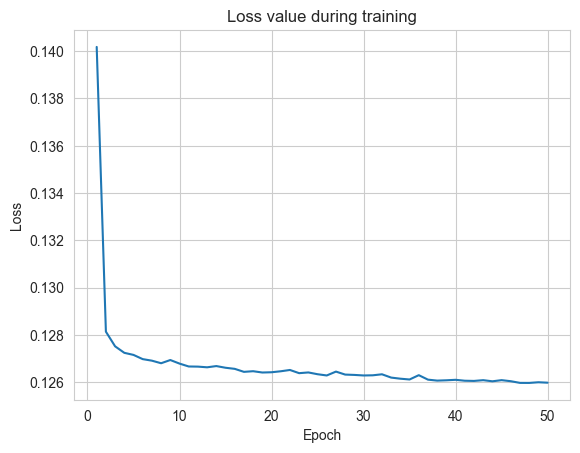

In [36]:
plt.plot(range(1, epochs+1), history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss value during training")
plt.show()

# Save the model to files

In [39]:
models_path = "./fine_models/autoencoder_v1/"
model_name = "encoder_model"

model_json = autoencoder_model.encoder.to_json()
with open(f"{models_path}{model_name}.json", "w") as json_file:
    json_file.write(model_json)
    
autoencoder_model.encoder.save_weights(f"{models_path}{model_name}.h5")

In [40]:
model_name = "decoder_model"

model_json = autoencoder_model.decoder.to_json()
with open(f"{models_path}{model_name}.json", "w") as json_file:
    json_file.write(model_json)
    
autoencoder_model.decoder.save_weights(f"{models_path}{model_name}.h5")

# Additional testings

In [37]:
encoded_embeddings = autoencoder_model.encoder.predict(data_generator(), steps=4282)

4282/4282 [==============================] - 206s 48ms/step


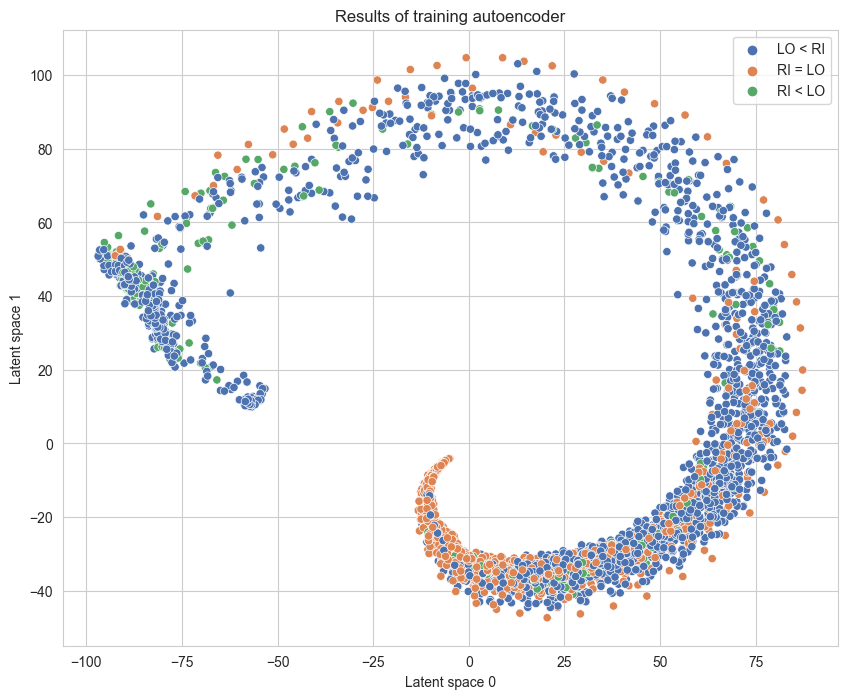

In [38]:
list_ls_0 = [ee[0] for ee in encoded_embeddings]
list_ls_1 = [ee[1] for ee in encoded_embeddings]

encoding_df = pd.DataFrame()
encoding_df["LS0"] = list_ls_0
encoding_df["LS1"] = list_ls_1
encoding_df["class"] = class_RI_LO


plt.figure(figsize=(10, 8))
sns.scatterplot(x='LS0', y='LS1', hue='class', data=encoding_df, palette="deep")
plt.title('Results of training autoencoder')
plt.xlabel('Latent space 0')
plt.ylabel('Latent space 1')
plt.legend()
plt.show()